# Cell type enrichment analysis

In [1]:
import os, errno
import functools
import numpy as np
import pandas as pd
from matplotlib_venn import venn3
from matplotlib import pyplot as plt
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

## Functions

### Cached functions

In [2]:
@functools.lru_cache()
def get_deg(tissue):
    fn = '../../../differential_expression/%s/_m/genes/diffExpr_maleVfemale_full.txt' % tissue
    return pd.read_csv(fn, sep='\t', index_col=0)


@functools.lru_cache()
def get_xci():
    return pd.read_csv('../../xci_status_hg19.txt', sep='\t')

### Simple functions

In [3]:
def tissue_annotation(tissue):
    return {'caudate': "Caudate", "dlpfc": "DLPFC", 
            "hippocampus": "Hippocampus"}[tissue]


def mkdir_p(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def cal_fishers(status, tissue):
    deg = get_deg(tissue)
    xci = get_xci()
    xci['ensemblID'] = xci['Gene ID'].str.replace("\\..*", "", regex=True)
    df = deg.merge(xci, on='ensemblID', how='left')
    table = [[np.sum((df['adj.P.Val']<0.05) & (df['Combined XCI status'] == status)), 
              np.sum((df['adj.P.Val']<0.05) & (df['Combined XCI status'] != status))], 
             [np.sum((df['adj.P.Val']>0.05) & (df['Combined XCI status'] == status)), 
              np.sum((df['adj.P.Val']>0.05) & (df['Combined XCI status'] != status))]]
    #print(table)
    return fisher_exact(table)


def cal_fishers_direction(status, direction, tissue):
    deg = get_deg(tissue)
    if direction == 'Up':
        deg = deg[(deg['t'] > 0)].copy()
    else:
        deg = deg[(deg['t'] < 0)].copy()
    xci = get_xci()
    xci['ensemblID'] = xci['Gene ID'].str.replace("\\..*", "", regex=True)
    df = deg.merge(xci, on='ensemblID', how='left')
    table = [[np.sum((df['adj.P.Val']<0.05) & (df['Combined XCI status'] == status)), 
              np.sum((df['adj.P.Val']<0.05) & (df['Combined XCI status'] != status))], 
             [np.sum((df['adj.P.Val']>0.05) & (df['Combined XCI status'] == status)), 
              np.sum((df['adj.P.Val']>0.05) & (df['Combined XCI status'] != status))]]
    #print(table)
    return fisher_exact(table)


def cal_fisher_by_xci_status(tissue):
    xci_status = xci = get_xci().loc[:, 'Combined XCI status'].unique()
    xci_lt = []; pval_lt = []; oddratio_lt = []; dir_lt = [];
    for status in xci_status:
        odd_ratio, pval = cal_fishers(status, tissue)
        xci_lt.append(status); pval_lt.append(pval);
        oddratio_lt.append(odd_ratio); dir_lt.append('All')
        if pval < 0.05:
            print("There is a significant enrichment (p-value < %.1e) of %s!" % 
                  (pval, status))

    for status in xci_status:
        odd_ratio, pval = cal_fishers_direction(status, "Up", tissue)
        xci_lt.append(status); pval_lt.append(pval);
        oddratio_lt.append(odd_ratio); dir_lt.append('Male Bias')
        if pval < 0.05:
            print("There is a significant enrichment of male bias genes (p-value < %.1e) of %s!" %
                  (pval, status))
        
    for status in xci_status:
        odd_ratio, pval = cal_fishers_direction(status, "Down", tissue)
        xci_lt.append(status); pval_lt.append(pval);
        oddratio_lt.append(odd_ratio); dir_lt.append('Female Bias')
        if pval < 0.05:
            print("There is a significant enrichment of female bias genes (p-value < %.1e) of %s!" % 
                  (pval, status))
    return pd.DataFrame({"Tissue": tissue_annotation(tissue),
                         'XCI status': xci_lt, 'OR': oddratio_lt, 
                         'PValue': pval_lt, 'Direction': dir_lt})

## Gene set overlaps

Caudate


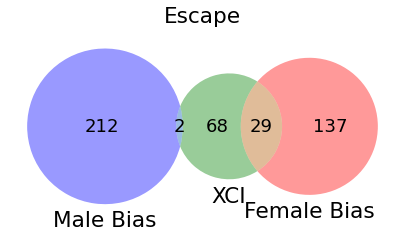

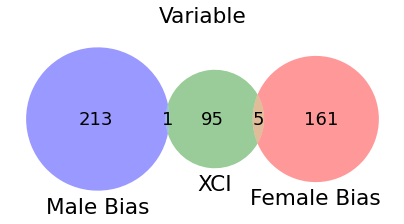

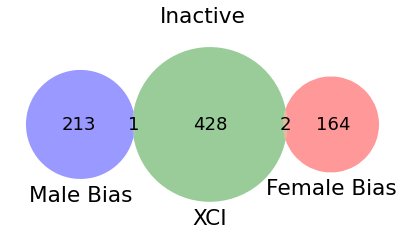

DLPFC


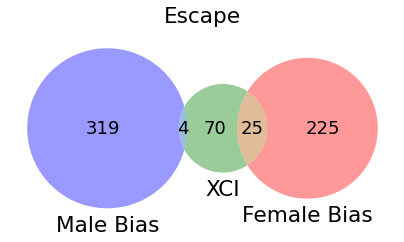

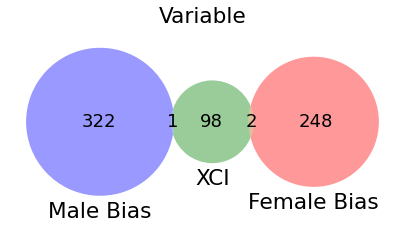

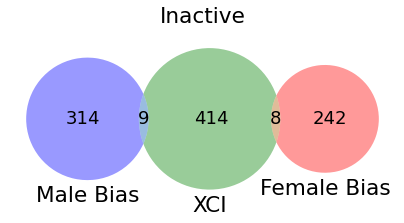

Hippocampus


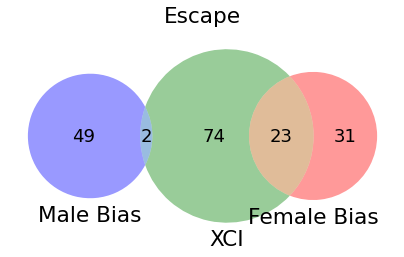

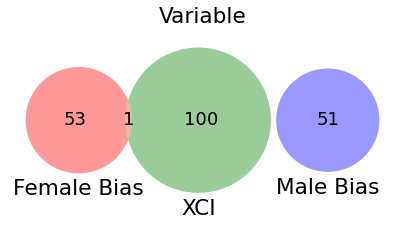

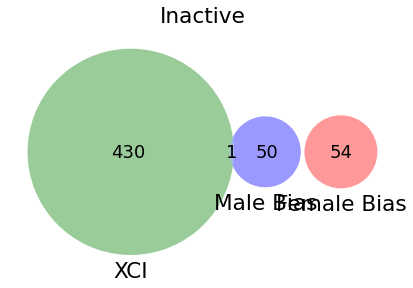

In [4]:
for tissue in ["caudate", "dlpfc", "hippocampus"]:
    mkdir_p(tissue)
    print(tissue_annotation(tissue))
    deg = get_deg(tissue)
    xci = get_xci()
    xci['ensemblID'] = xci['Gene ID'].str.replace("\\..*", "", regex=True)
    xci_status = get_xci().loc[:, 'Combined XCI status'].unique()
    ## Plot venn diagram
    for status in xci_status:
        setA = set(deg[(deg["adj.P.Val"] < 0.05) & (deg['t'] < 0)].ensemblID)
        setB = set(xci[(xci["Combined XCI status"] == status)].ensemblID)
        setC = set(deg[(deg["adj.P.Val"] < 0.05) & (deg['t'] > 0)].ensemblID)
        plt.rcParams.update({'font.size': 18})
        plt.figure(figsize=(7,7))
        v = venn3([setA, setB, setC], ("Female Bias", "XCI", "Male Bias"))
        plt.title(status.title())
        fn = '%s/venn_DEGs_%s' % (tissue, status)
        for ext in ['png', 'pdf', 'svg']:
            plt.savefig(fn + '.' + ext) 
        plt.show()

## Calculated fisher's exact for each XCI status

In [5]:
d = dict()
for tissue in ["caudate", "dlpfc", "hippocampus"]:
    print(tissue_annotation(tissue))
    df = cal_fisher_by_xci_status(tissue)
    _, fdr, _, _ = multipletests(df.PValue, method='bonferroni')
    df['Bonferroni'] = fdr
    d[tissue] = df

Caudate
There is a significant enrichment (p-value < 3.5e-37) of escape!
There is a significant enrichment (p-value < 1.0e-03) of variable!
There is a significant enrichment of female bias genes (p-value < 1.2e-42) of escape!
There is a significant enrichment of female bias genes (p-value < 8.6e-05) of variable!
DLPFC
There is a significant enrichment (p-value < 2.3e-28) of escape!
There is a significant enrichment (p-value < 2.0e-02) of inactive!
There is a significant enrichment of male bias genes (p-value < 3.8e-03) of escape!
There is a significant enrichment of female bias genes (p-value < 6.5e-30) of escape!
Hippocampus
There is a significant enrichment (p-value < 2.8e-41) of escape!
There is a significant enrichment of male bias genes (p-value < 2.4e-03) of escape!
There is a significant enrichment of female bias genes (p-value < 2.9e-41) of escape!


In [6]:
dft = pd.concat(d.values(), axis=0)
dft[(dft.Bonferroni <= 0.05)]

,Tissue,XCI status,OR,PValue,Direction,Bonferroni
0,Caudate,escape,52.541253,3.525156e-37,All,3.172640e-36
1,Caudate,variable,5.687289,1.018592e-03,All,9.167329e-03
6,Caudate,escape,136.346071,1.182377e-42,Female Bias,1.064139e-41
7,Caudate,variable,13.068562,8.613979e-05,Female Bias,7.752581e-04
0,DLPFC,escape,29.157326,2.319487e-28,All,2.087538e-27
3,DLPFC,escape,7.182445,3.797823e-03,Male Bias,3.418041e-02
6,DLPFC,escape,58.037037,6.541881e-30,Female Bias,5.887693e-29
0,Hippocampus,escape,148.678385,2.768297e-41,All,2.491467e-40
3,Hippocampus,escape,32.317784,2.362670e-03,Male Bias,2.126403e-02
6,Hippocampus,escape,256.447818,2.873171e-41,Female Bias,2.585853e-40


In [7]:
df.to_csv('xci_enrichment_analysis_3brainRegions.txt', sep='\t', index=False)